# PCAによる次元削減とSVMを用いたMNISTの分類

## はじめに
    MNISTという数字手書き文字のデータセットがある。このデータは28×28ピクセルの手書き数字の画像に対して、0から9までのラベルが振られたデータである。
    このレポートでは、10000枚の手書き数字の画像がそれぞれ0から9までのどの数字にあたるかを識別する、SVMを用いたモデルの生成、および生成モデルを用いた推論を実装する。また、性能向上のために用いた交差検証、グリッドサーチ、およびPCA(主成分分析)による次元削減についても記載する。
    
## レポートの構成について
    実行したコードの記載されたセルの次のセルにコードの内容、使用した手法などの説明を記載する形になっている。

In [2]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import NMF,PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
DATAPATH = "data/digits.csv"
image_shape=(28,28)
df = pd.read_csv(DATAPATH)
y = df["label"].values
labels = df["label"] 
X = df.drop("label",axis=1).values/255
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 0)

## データセットの用意
    ここでcsvからデータをロードし、画像データ、ラベルデータをそれぞれトレイン用のデータ、テスト用のデータに分割する。トレイン用のデータとテスト用のデータを分けることにより、生成したモデルの性能評価を行うことができる。
    また、ここではデータ分割にtrain_test_splitというランダムにトレインデータとテストデータを分割する関数を使用しているが、random_stateパラメータを任意に設定することで毎回同じ出力が発生するようにしてある。また、ロードしたターゲットデータは最大値の255割ってスケールしている。こうすることで学習時のパラメータ更新がパラメータごとに偏ることがなくなり、最適解を見つけるまでのステップが少なくなるというメリットがある。この処理を前処理という。

In [3]:
pca = PCA(0.8)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(pca.n_components_)
print(np.sum(pca.explained_variance_ratio_))

43
0.8013124141578981


## PCAによる次元削減
    ここでPCAによる次元削減を行う。PCAとは主成分を計算し、n次元のデータの内あるm(<<n)個の主成分でデータ全体の何%を説明できるかを分析することである。例えばここではオリジナルの画像データの分散の80%を説明できる主成分がいくつ必要かを求めている。結果、43個の変数でオリジナルの画像データの分散の80%が説明できることがわかる。次元削減を行うことで、過学習の抑制や計算時間の短縮が期待できる。

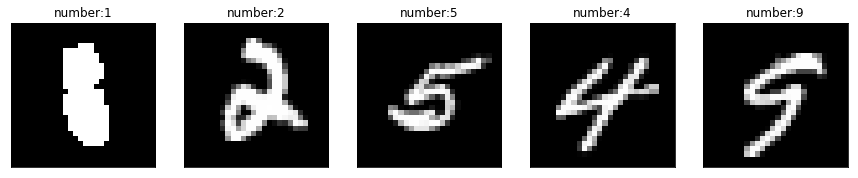

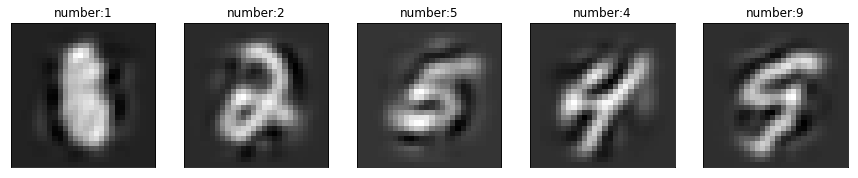

In [4]:
X_train_low = pca.inverse_transform(X_train_pca)
X_test_low = pca.inverse_transform(X_test_pca)
image_shape = [28,28]
fix, axes1 = plt.subplots(1,5,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})
fix2, axes2 = plt.subplots(1,5,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})

for i,ax in zip(range(5),axes1.ravel()):
    ax.imshow((X_train[i]*255).reshape(image_shape),cmap=plt.cm.gray)
    ax.set_title("number:{}".format(y_train[i]))
for i,ax in zip(range(5),axes2.ravel()):
    ax.imshow((X_train_low[i]*255).reshape(image_shape),cmap=plt.cm.gray)
    ax.set_title("number:{}".format(y_train[i]))


## 次元削減後のデータの可視化
    次元削減前の画像データと次元削減後の画像データを書き出して比較してみると、おおよそ元の特徴を保持しているように見える。

In [5]:
parameters = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
    ]
clf = svm.SVC(parameters)
clf = GridSearchCV(clf, parameters, verbose=2,n_jobs=-1,cv=2,return_train_score=True)
clf.fit(X_train,y_train)

Fitting 2 folds for each of 44 candidates, totalling 88 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed: 27.8min finished


In [7]:
print(clf.score(X_test,y_test))

0.959


In [6]:
clf_pca = svm.SVC(parameters)
clf_pca = GridSearchCV(clf_pca, parameters, verbose=2,n_jobs=-1,cv=2,return_train_score=True)
clf_pca.fit(X_train_pca,y_train)

Fitting 2 folds for each of 44 candidates, totalling 88 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:  2.4min finished


In [8]:
print(clf_pca.score(X_test_pca,y_test))

0.963


In [9]:
print("Best estimator found by grid search:")
print("Best parameters:{}".format(clf.best_params_))
print("Best parameters_pca:{}".format(clf_pca.best_params_))

Best estimator found by grid search:
Best parameters:{'C': 1000, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
Best parameters_pca:{'C': 1000, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}


In [5]:
clf_cv = svm.SVC(C=1000,degree=2,gamma=0.001,kernel="poly")
print("Normal CV score:",cross_val_score(clf_cv,X_train,y_train,cv=5,verbose=2,n_jobs=-1))
print("PCA CV score:",cross_val_score(clf_cv,X_train_pca,y_train,cv=5,verbose=2,n_jobs=-1))

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.3s finished


Normal CV score: [0.96323988 0.95942572 0.95309568 0.95682103 0.95551378]
PCA CV score: [0.96448598 0.96067416 0.95559725 0.95932416 0.95864662]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


In [18]:
cv_result_df = pd.DataFrame(clf_pca.cv_results_)
pd.set_option('display.max_colwidth',100)
maxidx = cv_result_df["mean_test_score"].idxmax()
minidx = cv_result_df["mean_test_score"].idxmin()
print(cv_result_df.loc[maxidx,["params","mean_test_score"]])
print(cv_result_df.loc[minidx,["params","mean_test_score"]])

params             {'C': 1000, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
mean_test_score                                                      0.952125
Name: 30, dtype: object
params             {'C': 1, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
mean_test_score                                                    0.10925
Name: 12, dtype: object


C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\

In [6]:
#結果検証
y_pred = clf.predict(X_test)
print(test_score)
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred, labels=range(10)))

0.9515
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       203
          1       0.96      0.97      0.97       217
          2       0.94      0.92      0.93       230
          3       0.94      0.96      0.95       183
          4       0.95      0.96      0.96       194
          5       0.95      0.92      0.94       178
          6       0.96      0.99      0.98       203
          7       0.97      0.93      0.95       215
          8       0.93      0.92      0.93       182
          9       0.93      0.95      0.94       195

avg / total       0.95      0.95      0.95      2000

[[201   0   0   0   1   0   0   0   1   0]
 [  0 210   1   2   2   0   2   0   0   0]
 [  1   5 212   0   2   1   3   2   2   2]
 [  0   0   3 175   0   1   0   1   1   2]
 [  0   0   0   0 187   0   2   1   0   4]
 [  1   0   3   3   0 164   0   0   5   2]
 [  0   0   0   0   0   2 201   0   0   0]
 [  3   2   5   1   3   0   0 200   0   1]
 [  0   1 

In [ ]:
#結果検証pca
y_pred_pca = clf_pca.predict(X_test_pca)
print(test_score)
print(metrics.classification_report(y_test, y_pred_pca, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred_pca, labels=range(10)))